## Question 1

In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/xiazheng/Desktop/UVA/Courses25-26/S1P4/Computaional_Biology/assignments/assignment1/Kinetics.csv")
S1 = df["S1"].to_numpy(dtype=float)
S2 = df["S2"].to_numpy(dtype=float)
vlt = df["Rate"].to_numpy(dtype=float)

# assume constant sigma for chi-square scaling
sigma = np.full_like(vlt, fill_value = np.std(vlt)*0.02)
sigma = np.where(sigma <= 0, 1.0, sigma)

In [3]:
def pingpong_bibi(params, s1, s2):
    """ 
    v = Vmax * s1 * s2 / (Km2 * s1 + Km1 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2]
    """
    Vmax, Km1, Km2 = params
    num = Vmax * s1 * s2 
    den = Km2 * s1 + Km1 * s2 + s1 * s2
    return num / den

def sequential_type1a(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + s1 * s2)
    params = [Vmax, Km1, Kis1]
    """
    Vmax, Km1, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + s1 * s2
    return num / den

def sequential_type1b(params, s1, s2):
    """
    v = Vmax * s1 * s2 / (Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2)
    params = [Vmax, Km1, Km2, Kis1]
    """
    Vmax, Km1, Km2, Kis1 = params
    num = Vmax * s1 * s2
    den = Kis1 * Km1 + Km1 * s1 + Km2 * s2 + s1 * s2
    return num / den

In [4]:
@dataclass
class FitResult:
    name: str
    params: np.ndarray
    success: bool
    r2: float
    chi2: float
    red_chi2: float

In [5]:
def r2_score(y, yhat):
    ss_res = np.sum((y-yhat)**2)
    ss_tot = np.sum((y-np.mean(y)) ** 2)
    return 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

def fit_model(model_fun, name, p0, bounds, s1, s2, v, sigma):
    """
    Weighted least squares fit using least_squares.
    Minimize sum(((v-model)/sigma)^2).
    """
    def residuals(p):
        return (v-model_fun(p,s1,s2))/sigma
    
    res = least_squares(residuals, x0=np.array(p0, dtype=float), bounds=bounds, method="trf")
    p_hat = res.x
    v_hat = model_fun(p_hat, s1, s2)

    chi2 = np.sum(((v-v_hat)/sigma)**2)
    dof = max(len(v) - len(p_hat), 1)
    red_chi2 = chi2 / dof 
    r2 = r2_score(v, v_hat)

    return FitResult(
        name = name,
        params = p_hat,
        success = res.success,
        r2 = r2,
        chi2 = chi2,
        red_chi2 = red_chi2,
    )

In [6]:
# Initial guess
Vmax0 = np.max(vlt)
Km10 = np.median(S1)
Km20 = np.median(S2)
Kis10 = Km10

# Enforce positivity for kinetic constants
pos_low = 1e-12

fits = []

# Ping-pong
fits.append(
    fit_model(
        pingpong_bibi,
        "PingPong",
        p0 = [Vmax0, Km10, Km20],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequantial type 1a
fits.append(
    fit_model(
        sequential_type1a,
        "Sequential type 1a",
        p0 = [Vmax0, Km10, Kis10],
        bounds = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Sequential type 1b 
fits.append(
    fit_model(
        sequential_type1b,
        "Sequential type 1b",
        p0 = [Vmax0, Km10, Km20, Kis10],
        bounds = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf]),
        s1 = S1, s2 = S2, v = vlt, sigma = sigma
    )
)

# Print comparison
fits_sorted = sorted(fits, key = lambda fr: fr.red_chi2)
for fr in fits_sorted:
    print(f"\n==={fr.name}===")
    print("success  :", fr.success)
    print("params   :", fr.params)
    print("R^2      :", fr.r2)
    print("chi^2    :", fr.chi2)
    print("red chi^2:", fr.red_chi2)

best = fits_sorted[0]
print("\nBest by reduced chi-square:", best.name)


===PingPong===
success  : True
params   : [1.  0.1 0.1]
R^2      : 1.0
chi^2    : 1.2435069832463078e-25
red chi^2: 4.186892199482518e-28

===Sequential type 1b===
success  : True
params   : [9.99999990e-01 9.99999944e-02 9.99999942e-02 2.05561549e-08]
R^2      : 0.9999999999999994
chi^2    : 4.5459515716978655e-10
red chi^2: 1.5357944498979276e-12

===Sequential type 1a===
success  : True
params   : [0.78808214 0.03331481 0.59980728]
R^2      : 0.8095529965199977
chi^2    : 142835.25261000168
red chi^2: 480.9267764646521

Best by reduced chi-square: PingPong


Both ping-pong and sequential-random can fit the dataset nearly perfectly. However, the sequential-random fit collapses with Kis1≈0, indicating the extra term is not supported (parameter degeneracy).

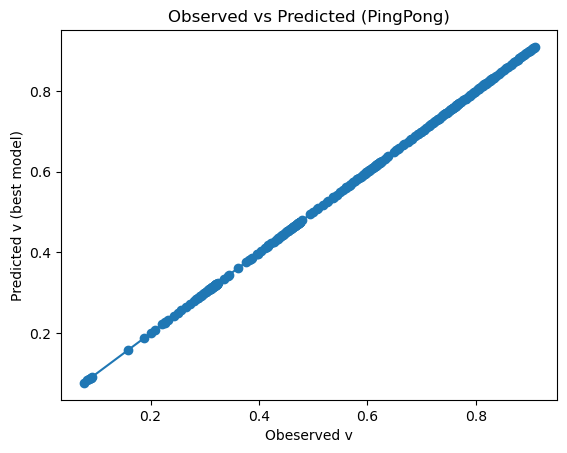

In [7]:
model_map = {
    "PingPong": pingpong_bibi,
    "Sequential type 1a": sequential_type1a,
    "Sequential type 1b": sequential_type1b,
}

best_fun = model_map[best.name]
v_best = best_fun(best.params, S1, S2)

plt.figure()
plt.scatter(vlt, v_best)
mn,mx = min(vlt.min(), v_best.min()), max(vlt.max(), v_best.max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Obeserved v")
plt.ylabel("Predicted v (best model)")
plt.title(f"Observed vs Predicted ({best.name})")
plt.show()

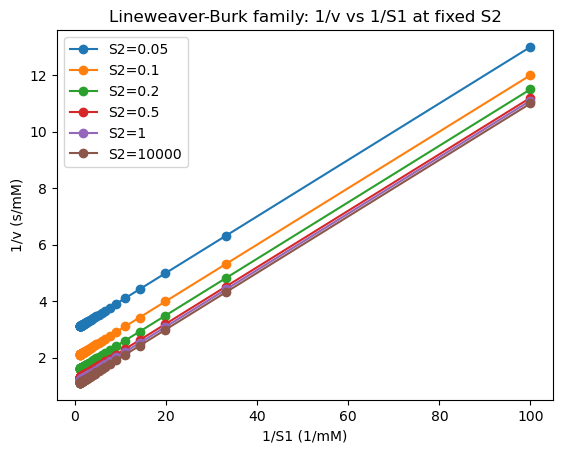

In [8]:
for s2_val, sub in df.groupby("S2"):
    sub = sub.sort_values("S1")
    x = 1.0 / sub["S1"].to_numpy()
    y = 1.0 / sub["Rate"].to_numpy()
    plt.plot(x, y, marker = "o", linestyle = "-", label = f"S2={s2_val:g}")

plt.xlabel("1/S1 (1/mM)")
plt.ylabel("1/v (s/mM)")
plt.title("Lineweaver-Burk family: 1/v vs 1/S1 at fixed S2")
plt.legend()
plt.show()


Bootstrap success rate: 1.000 (kept 1000 fits)
 Vmax: median=1, 95% CI=(1, 1)
  Km1: median=0.1, 95% CI=(0.1, 0.1)
  Km2: median=0.1, 95% CI=(0.1, 0.1)


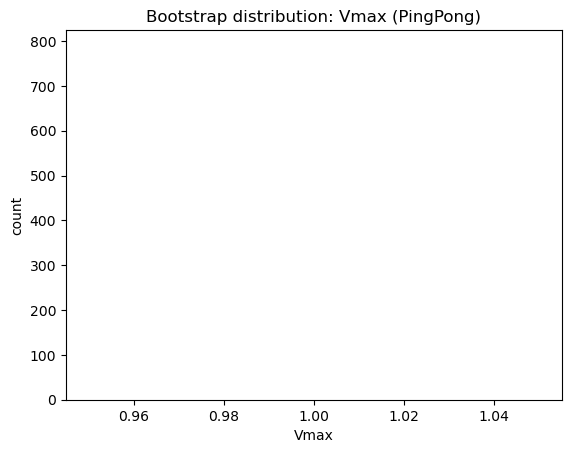

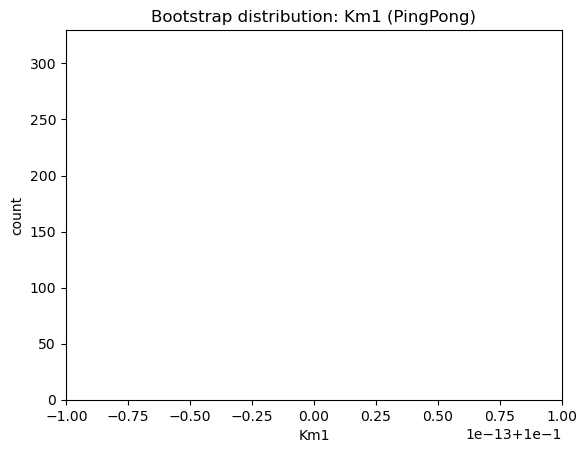

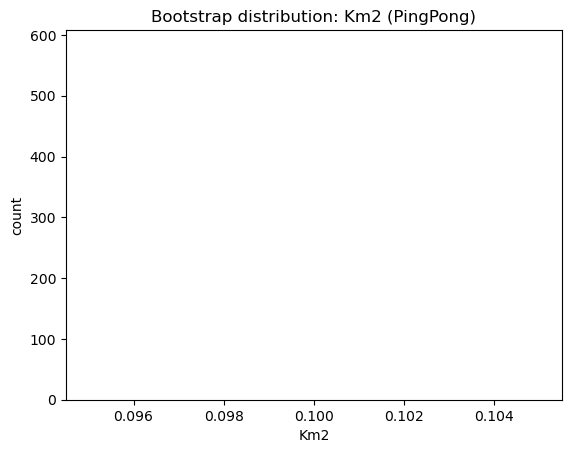

In [9]:
# Stochastic results: bootstrap parameter distributions
def bootstrap_fit(model_fun, name, p0, bounds, s1, s2, v, sigma, B =1000, seed = 0):
    """
    Nonparametric bootstrap: resample rows with replacement, refit each time.
    Returns array of shape (B, n_params).
    """
    rng = np.random.default_rng(seed)
    n = len(v)
    n_params = len(p0)
    samples = np.zeros((B,n_params), dtype=float)
    ok = np.zeros(B, dtype=bool)
    for b in range(B):
        idx = rng.integers(0, n, size = n)
        s1b, s2b, vb, sigb = s1[idx], s2[idx], v[idx], sigma[idx]

        fr = fit_model(model_fun, name, p0, bounds, s1b, s2b, vb, sigb)
        samples[b,:] = fr.params
        ok[b] = fr.success
    
    return samples, ok

if best.name == "PingPong":
    p0_best = [Vmax0, Km10, Km20]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
elif best.name == "Sequential type 1a":
    p0_best = [Vmax0, Km10, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf])
else:
    p0_best = [Vmax0, Km10, Km20, Kis10]
    bounds_best = ([pos_low, pos_low, pos_low, pos_low], [np.inf, np.inf, np.inf, np.inf])

samples, ok = bootstrap_fit(best_fun, best.name, p0_best, bounds_best, S1, S2, vlt, sigma, B=1000, seed=42)
samples_ok = samples[ok]

print(f"\nBootstrap success rate: {ok.mean():.3f} (kept {samples_ok.shape[0]} fits)")

# Summaries (95% CI)
param_names = {
    "PingPong": ["Vmax", "Km1", "Km2"],
    "Sequential type 1a": ["Vmax", "Km1", "Kis1"],
    "Sequential type 1b": ["Vmax", "Km1", "Km2", "Kis1"],
}[best.name]

for j, nm in enumerate(param_names):
    vals = samples_ok[:, j]
    lo, med, hi = np.percentile(vals, [2.5, 50, 97.5])
    print(f"{nm:>5s}: median={med:.6g}, 95% CI=({lo:.6g}, {hi:.6g})")

# Plot bootstrap histograms
for j, nm in enumerate(param_names):
    plt.figure()
    plt.hist(samples_ok[:, j], bins=40)
    plt.xlabel(nm)
    plt.ylabel("count")
    plt.title(f"Bootstrap distribution: {nm} ({best.name})")
    plt.show()

In [10]:
MW = 150.0  # g/mol
S0_gL = 100.0
Sf_gL = 1.0

Vmax = 1.0  # mM/s
Km = 0.1    # mM

# Convert g/L -> mM
S0_mM = (S0_gL / MW) * 1000.0
Sf_mM = (Sf_gL / MW) * 1000.0

# Integrated Michaelis–Menten batch time:
# t = (S0 - Sf)/Vmax + (Km/Vmax)*ln(S0/Sf)
t_sec = (S0_mM - Sf_mM) / Vmax + (Km / Vmax) * np.log(S0_mM / Sf_mM)

print("S0 (mM):", S0_mM)
print("Sf (mM):", Sf_mM)
print("Time (s):", t_sec)
print("Time (min):", t_sec / 60.0)


S0 (mM): 666.6666666666666
Sf (mM): 6.666666666666667
Time (s): 660.4605170185988
Time (min): 11.007675283643314


## Question 2 

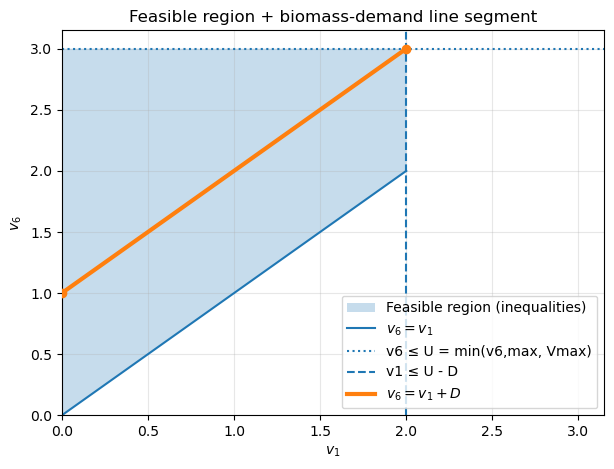

U = min(v6_max, Vmax) = 3.0
Feasible: yes
Segment endpoints:
  (v1, v6) = (0, D) = (0, 1.0)
  (v1, v6) = (U-D, U) = (2.0, 3.0)


In [24]:
v6_max = 5.0   # v_{6,max}
Vmax   = 3.0   # V_max from MM kinetics (cap on v6)
D      = 1.0   # biomass demand v9 = D
U = min(v6_max, Vmax)

v1 = np.linspace(0, U-D, 400)

plt.figure(figsize=(7, 5))
plt.fill_between(v1, v1, U, alpha=0.25, label="Feasible region (inequalities)")

# Boundary lines
plt.plot(v1, v1, label=r"$v_6 = v_1$")
#plt.axhline(v6_max, linestyle="--", label="v6 ≤ v6,max")
#plt.axhline(Vmax,   linestyle="--", label="v6 ≤ Vmax")
plt.axhline(U,      linestyle=":",  label="v6 ≤ U = min(v6,max, Vmax)")
if D <= U:
    v1_max = U - D
    plt.axvline(v1_max, linestyle="--", label=f"v1 ≤ U - D")


v1_line = np.linspace(0, U, 400)
v6_line = v1_line + D

ok = (v1_line >= 0) & (v1_line <= U-D) & (v6_line <= U) 

if np.any(ok):
    plt.plot(v1_line[ok], v6_line[ok], linewidth=3, label=r"$v_6 = v_1 + D$")
    # Mark endpoints of the feasible segment
    v1_lo, v1_hi = v1_line[ok][0], v1_line[ok][-1]
    plt.scatter([v1_lo, v1_hi], [v1_lo + D, v1_hi + D], zorder=5)
    plt.title("Feasible region + biomass-demand line segment")
else:
    plt.plot(v1_line, v6_line, linewidth=3, label=r"$v_6 = v_1 + D$ (no feasible intersection)")
    plt.title("No feasible solution: D exceeds v6 capacity")

plt.xlim(0, U * 1.05 if U > 0 else 1)
plt.ylim(0, U * 1.05 if U > 0 else max(D, 1) * 1.05)
plt.xlabel(r"$v_1$")
plt.ylabel(r"$v_6$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("U = min(v6_max, Vmax) =", U)
if D <= U:
    print("Feasible: yes")
    print("Segment endpoints:")
    print("  (v1, v6) = (0, D) =", (0, D))
    print("  (v1, v6) = (U-D, U) =", (U - D, U))
else:
    print("Feasible: no, because D > U")

